In [1]:
!pip install opencv-python==4.2.0.34 
!pip install pandas
#!apt update && apt install -y libsm6 libxext6
#!apt-get install -y libxrender-dev

You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
import os
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = "1" #please put your GPU

In [4]:
import pandas as pd
import numpy as np
import cv2
data_path = 'dataForClass.csv'
image_size=(48,48)
#image_size=(224,224)

def load_data(data_path):
        data = pd.read_csv(data_path)
        pixels = data['pixels'].tolist()
        width, height = 48, 48
        faces = []
        for pixel_sequence in pixels:
            face = [int(pixel) for pixel in pixel_sequence.split(' ')]
            face = np.asarray(face).reshape(width, height)
            face = cv2.resize(face.astype('uint8'),image_size)
            faces.append(face.astype('float32'))
        faces = np.asarray(faces)
        faces = np.expand_dims(faces, -1)

        emotions = pd.get_dummies(data['emotion']).values
        return faces, emotions
    
faces, emotions = load_data(data_path); 

### A sample face

Emotion Labels [1 0 0 0 0 0]


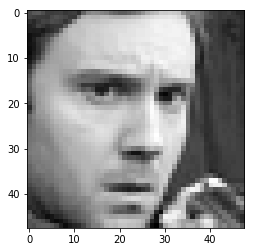

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
ind = 0
f = faces[ind, :,:,0]
print('Emotion Labels', emotions[ind,:])
plt.imshow(f, cmap='gray')

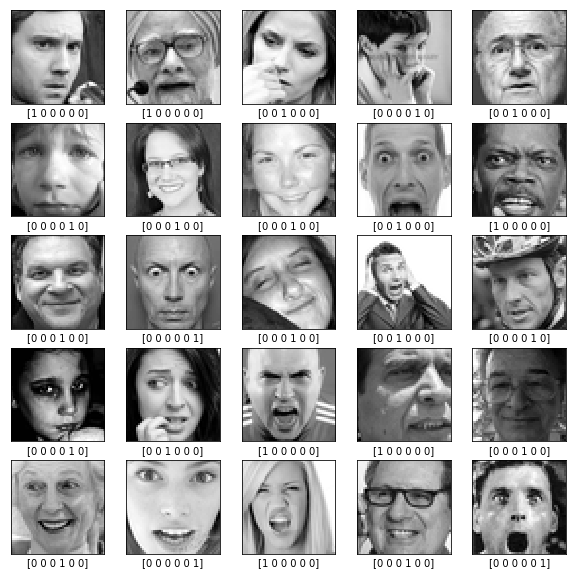

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10,10))

# Show first 25 training images below
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(faces[i, :, :, 0], cmap='gray')
    plt.xlabel(emotions[i,:])

In [7]:
faces.shape, emotions.shape

((23744, 48, 48, 1), (23744, 6))

### Building CNN

In [8]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras import models, Sequential
from tensorflow.keras import optimizers, Input
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50

In [13]:
from tensorflow import Tensor
from tensorflow.keras.layers import Input, Conv2D, ReLU, BatchNormalization,\
                                    Add, AveragePooling2D, Flatten, Dense
from tensorflow.keras.models import Model

def relu_bn(inputs: Tensor) -> Tensor:
    relu = ReLU()(inputs)
    bn = BatchNormalization()(relu)
    return bn

def residual_block(x: Tensor, downsample: bool, filters: int, kernel_size: int = 3) -> Tensor:
    y = Conv2D(kernel_size=kernel_size,
               strides= (1 if not downsample else 2),
               filters=filters,
               padding="same")(x)
    y = relu_bn(y)
    y = Conv2D(kernel_size=kernel_size,
               strides=1,
               filters=filters,
               padding="same")(y)

    if downsample:
        x = Conv2D(kernel_size=1,
                   strides=2,
                   filters=filters,
                   padding="same")(x)
    out = Add()([x, y])
    out = relu_bn(out)
    return out

def create_res_net():
    
    inputs = Input(shape=(48, 48, 1))
    num_filters = 16
    
    t = BatchNormalization()(inputs)
    t = Conv2D(kernel_size=3,
               strides=1,
               filters=num_filters,
               padding="same")(t)
    t = relu_bn(t)
    
    
    t= residual_block(t,False,16,5)
    t= residual_block(t,True,32,1)
    t= residual_block(t,False,32,4)
    t= residual_block(t,True,64,1)
    t= residual_block(t,False,64,4)
    

    t = BatchNormalization()(t)
    
    t = GlobalAveragePooling2D()(t)
    outputs = Dense(6, activation='softmax')(t)
    
    model = Model(inputs, outputs)



    return model

In [14]:
train_batchsize = 128
validation_batchsize = 128

datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    horizontal_flip=True,
    validation_split=0.2)

train_generator = datagen.flow(
    x = faces,
    y = emotions,
    shuffle = True,
    batch_size=train_batchsize,
    subset='training') # set as training data

validation_generator = datagen.flow(
    x = faces,
    y = emotions,
    batch_size=validation_batchsize,
    subset='validation') # set as validation data

# Define your optimizer here
optim ='adam'
model = create_res_net() 
print(model.summary())
model.compile(loss='categorical_crossentropy',
              optimizer=optim,
              metrics=['acc'])


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 48, 48, 1)    0                                            
__________________________________________________________________________________________________
batch_normalization_v1_13 (Batc (None, 48, 48, 1)    4           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 48, 48, 16)   160         batch_normalization_v1_13[0][0]  
__________________________________________________________________________________________________
re_lu_11 (ReLU)                 (None, 48, 48, 16)   0           conv2d_13[0][0]                  
__________________________________________________________________________________________________
batch_norm

In [15]:
# save the model
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='xuzhi.h5', mode='max', monitor='val_acc', verbose=2, save_best_only=True)
callbacks_list = [checkpoint]

epochs = 250

model.fit_generator(
      train_generator,
      steps_per_epoch=train_generator.n/train_generator.batch_size ,
      epochs=epochs,
      validation_data=validation_generator,
      validation_steps=validation_generator.n/validation_generator.batch_size,
      verbose=1,
      callbacks=callbacks_list)

Instructions for updating:
Use tf.cast instead.
Epoch 1/250
38/38 [==============================] - 2s 58ms/step - loss: 1.7311 - acc: 0.2026

Epoch 00001: val_acc improved from -inf to 0.20261, saving model to xuzhi.h5
149/149 [==============================] - 14s 96ms/step - loss: 1.6078 - acc: 0.3440 - val_loss: 1.7311 - val_acc: 0.2026
Epoch 2/250
38/38 [==============================] - 2s 63ms/step - loss: 1.5438 - acc: 0.3673

Epoch 00002: val_acc improved from 0.20261 to 0.36731, saving model to xuzhi.h5
149/149 [==============================] - 10s 67ms/step - loss: 1.3584 - acc: 0.4548 - val_loss: 1.5438 - val_acc: 0.3673
Epoch 3/250
38/38 [==============================] - 2s 55ms/step - loss: 1.4916 - acc: 0.4406

Epoch 00003: val_acc improved from 0.36731 to 0.44061, saving model to xuzhi.h5
149/149 [==============================] - 10s 66ms/step - loss: 1.2501 - acc: 0.5060 - val_loss: 1.4916 - val_acc: 0.4406
Epoch 4/250
38/38 [==============================] - 2s 55

Epoch 29/250
38/38 [==============================] - 2s 61ms/step - loss: 0.9308 - acc: 0.6365

Epoch 00029: val_acc did not improve from 0.64848
149/149 [==============================] - 10s 66ms/step - loss: 0.7782 - acc: 0.6966 - val_loss: 0.9308 - val_acc: 0.6365
Epoch 30/250
38/38 [==============================] - 2s 60ms/step - loss: 0.9282 - acc: 0.6382

Epoch 00030: val_acc did not improve from 0.64848
149/149 [==============================] - 9s 63ms/step - loss: 0.7750 - acc: 0.7012 - val_loss: 0.9282 - val_acc: 0.6382
Epoch 31/250
38/38 [==============================] - 2s 61ms/step - loss: 0.9209 - acc: 0.6394: 0s - loss: 0.9312 - acc

Epoch 00031: val_acc did not improve from 0.64848
149/149 [==============================] - 10s 65ms/step - loss: 0.7641 - acc: 0.7046 - val_loss: 0.9209 - val_acc: 0.6394
Epoch 32/250
38/38 [==============================] - 2s 63ms/step - loss: 0.8815 - acc: 0.6508

Epoch 00032: val_acc improved from 0.64848 to 0.65080, saving model t

Epoch 59/250
38/38 [==============================] - 2s 56ms/step - loss: 0.9398 - acc: 0.6495

Epoch 00059: val_acc did not improve from 0.66470
149/149 [==============================] - 9s 63ms/step - loss: 0.6356 - acc: 0.7548 - val_loss: 0.9398 - val_acc: 0.6495
Epoch 60/250
38/38 [==============================] - 2s 60ms/step - loss: 0.9012 - acc: 0.6662

Epoch 00060: val_acc improved from 0.66470 to 0.66618, saving model to xuzhi.h5
149/149 [==============================] - 10s 67ms/step - loss: 0.6302 - acc: 0.7585 - val_loss: 0.9012 - val_acc: 0.6662
Epoch 61/250
38/38 [==============================] - 2s 60ms/step - loss: 0.9346 - acc: 0.6592

Epoch 00061: val_acc did not improve from 0.66618
149/149 [==============================] - 10s 66ms/step - loss: 0.6267 - acc: 0.7594 - val_loss: 0.9346 - val_acc: 0.6592
Epoch 62/250
38/38 [==============================] - 2s 58ms/step - loss: 0.9355 - acc: 0.6605

Epoch 00062: val_acc did not improve from 0.66618
149/149 [=====

Epoch 89/250
38/38 [==============================] - 2s 56ms/step - loss: 0.9560 - acc: 0.6580

Epoch 00089: val_acc did not improve from 0.67586
149/149 [==============================] - 10s 64ms/step - loss: 0.5461 - acc: 0.7895 - val_loss: 0.9560 - val_acc: 0.6580
Epoch 90/250
38/38 [==============================] - 2s 58ms/step - loss: 0.9689 - acc: 0.6594

Epoch 00090: val_acc did not improve from 0.67586
149/149 [==============================] - 10s 65ms/step - loss: 0.5332 - acc: 0.7928 - val_loss: 0.9689 - val_acc: 0.6594
Epoch 91/250
38/38 [==============================] - 2s 59ms/step - loss: 0.9891 - acc: 0.6628

Epoch 00091: val_acc did not improve from 0.67586
149/149 [==============================] - 10s 64ms/step - loss: 0.5373 - acc: 0.7971 - val_loss: 0.9891 - val_acc: 0.6628
Epoch 92/250
38/38 [==============================] - 2s 58ms/step - loss: 0.9118 - acc: 0.6662

Epoch 00092: val_acc did not improve from 0.67586
149/149 [==============================] - 

38/38 [==============================] - 2s 58ms/step - loss: 0.9976 - acc: 0.6641

Epoch 00149: val_acc did not improve from 0.67965
149/149 [==============================] - 10s 65ms/step - loss: 0.4356 - acc: 0.8335 - val_loss: 0.9976 - val_acc: 0.6641
Epoch 150/250
38/38 [==============================] - 2s 57ms/step - loss: 1.0240 - acc: 0.6647

Epoch 00150: val_acc did not improve from 0.67965
149/149 [==============================] - 9s 64ms/step - loss: 0.4373 - acc: 0.8352 - val_loss: 1.0240 - val_acc: 0.6647
Epoch 151/250
38/38 [==============================] - 2s 63ms/step - loss: 1.1105 - acc: 0.6561

Epoch 00151: val_acc did not improve from 0.67965
149/149 [==============================] - 10s 67ms/step - loss: 0.4259 - acc: 0.8355 - val_loss: 1.1105 - val_acc: 0.6561
Epoch 152/250
38/38 [==============================] - 2s 57ms/step - loss: 1.0471 - acc: 0.6679

Epoch 00152: val_acc did not improve from 0.67965
149/149 [==============================] - 10s 66ms/st

38/38 [==============================] - 2s 60ms/step - loss: 1.0626 - acc: 0.6708

Epoch 00209: val_acc did not improve from 0.67965
149/149 [==============================] - 10s 66ms/step - loss: 0.3753 - acc: 0.8571 - val_loss: 1.0626 - val_acc: 0.6708
Epoch 210/250
38/38 [==============================] - 2s 58ms/step - loss: 1.1453 - acc: 0.6599

Epoch 00210: val_acc did not improve from 0.67965
149/149 [==============================] - 10s 65ms/step - loss: 0.3707 - acc: 0.8612 - val_loss: 1.1453 - val_acc: 0.6599
Epoch 211/250
38/38 [==============================] - 2s 60ms/step - loss: 1.1014 - acc: 0.6641

Epoch 00211: val_acc did not improve from 0.67965
149/149 [==============================] - 9s 61ms/step - loss: 0.3788 - acc: 0.8580 - val_loss: 1.1014 - val_acc: 0.6641
Epoch 212/250
38/38 [==============================] - 2s 59ms/step - loss: 1.1435 - acc: 0.6594

Epoch 00212: val_acc did not improve from 0.67965
149/149 [==============================] - 10s 66ms/st

### Saving the model

In [17]:
# save your model and weight (only submit best model)
model_json = model.to_json()
with open("xuzhi.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights('xuzhi.h5')

### Testing

In [18]:
# Your model will be tested as following

# Model reconstruction from JSON file
with open('xuzhi.json', 'r') as json_file:
    json_savedModel= json_file.read()

test_model = tf.keras.models.model_from_json(json_savedModel)
test_model.summary()

test_model.compile(loss='categorical_crossentropy',
              optimizer=optim,
              metrics=['acc'])

# Load weights into the new model
test_model.load_weights('xuzhi.h5')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 48, 48, 1)    0                                            
__________________________________________________________________________________________________
batch_normalization_v1_13 (Batc (None, 48, 48, 1)    4           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 48, 48, 16)   160         batch_normalization_v1_13[0][0]  
__________________________________________________________________________________________________
re_lu_11 (ReLU)                 (None, 48, 48, 16)   0           conv2d_13[0][0]                  
__________________________________________________________________________________________________
batch_norm

In [19]:
## Testing
import cv2
data_path = 'dataForClass.csv'  ##### change to test data file name #####
image_size=(48,48)
#image_size=(224,224)

def load_data(data_path):
        data = pd.read_csv(data_path)
        pixels = data['pixels'].tolist()
        width, height = 48, 48
        faces = []
        for pixel_sequence in pixels:
            face = [int(pixel) for pixel in pixel_sequence.split(' ')]
            face = np.asarray(face).reshape(width, height)
            face = cv2.resize(face.astype('uint8'),image_size)
            faces.append(face.astype('float32'))
        faces = np.asarray(faces)
        faces = np.expand_dims(faces, -1)

        emotions = pd.get_dummies(data['emotion']).values
        return faces, emotions
    
faces_test, emotions_test = load_data(data_path); 

test_loss, test_acc = test_model.evaluate(faces_test/255.0, emotions_test) 
print('Test accuracy:', test_acc)

23744/23744 [==============================] - 5s 191us/sample - loss: 0.4895 - acc: 0.8470
Test accuracy: 0.84703505


In [20]:
print(tf.__version__)

1.13.1
